In [213]:
import numpy as np 
import pandas as pd 
import warnings
import csv
import langid
from langdetect import detect
import os 
import spacy
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from spacy.lang.ar import Arabic
from sklearn import preprocessing
import seaborn as sns 
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix, f1_score, precision_score, recall_score
import nltk 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from collections import Counter 
import re
import string
import matplotlib.cm as cm
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import VotingClassifier

## Combine Data

In [2]:
# # replace with your folder's path
# folder_path = 'C:/Users/rawan/OneDrive/Desktop/NLP/Sentiment-Analysis-for-STC-Arabic-Tweets-1/Labeled Data'

# all_files = os.listdir(folder_path)

# # Filter out non-CSV files
# csv_files = [f for f in all_files if f.endswith('.csv')]

# # Create a list to hold the dataframes
# df_list = []

# for csv in csv_files:
#     file_path = os.path.join(folder_path, csv)
#     try:
#         # Try reading the file using default UTF-8 encoding
#         df = pd.read_csv(file_path)
#         df_list.append(df)
#     except UnicodeDecodeError:
#         try:
#             # If UTF-8 fails, try reading the file using UTF-16 encoding with tab separator
#             df = pd.read_csv(file_path, sep='\t', encoding='utf-16')
#             df_list.append(df)
#         except Exception as e:
#             print(f"Could not read file {csv} because of error: {e}")
#     except Exception as e:
#         print(f"Could not read file {csv} because of error: {e}")

# # Concatenate all data into one DataFrame
# big_df = pd.concat(df_list, ignore_index=True)



In [3]:
# Save the final result to a new CSV file
# big_df.to_csv(os.path.join(folder_path, 'combined_file.csv'), index=False)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1)
pd.set_option('display.max_rows', None)

In [5]:
df = pd.read_csv('Labeled Data/combined_file.csv')

In [6]:
df.head(10)

,date,Tweet,label
0,2020-05-27 04:41:01,ياخي ارسلت اكثر مره احد خدمني عندي شريحة مسبقة الدفع ابي افعل الجيل الخامس محدود يقبل معي ماي اس سي ليه,0.0
1,2020-05-27 03:47:08,ابي افعل انترنت الجيل الخامس لمده شهر محدود لشريحه كويك نت و رصيد يغطي جربت عشرين مره ماي اس سي و لاضبط امل حل مشكلتي و شكرا والا فعلوها عندكم و خلصنا تو ارسلت بالخاص قالي الموظف حاول مره اخرى سلامات حل اسبوع احاول,-1.0
2,2020-05-27 03:45:29,اخوي شحنت رصيد بفعل خدمه مو راضي طريق ماي اس سي,-1.0
3,2020-05-27 03:07:36,سلام علكيم عام وانتو بخير انا جيت تطبيق ماي اس سي مالقيت ايفون اكس اس ماكس متوفره,0.0
4,2020-05-27 01:45:20,الله يحيك تم طلبها طريق ماي اس سي يوم ويجيني النت وتتفعل الخدمه,1.0
5,2020-05-27 00:58:13,طريق ماي اس سي,0.0
6,2020-05-26 22:49:22,طريقة استخراج بدل فاقد للشريحه ماي اس سي,0.0
7,2020-05-26 18:56:54,اريد التواصل موظف خدمة العملاء بتصل ب بدون اي فائدة رد مفهوم مرة يقول حمل تطبيق ماي اس سي خلال التطبيق ستنجز معاملاتك للاسف,-1.0
8,2020-05-26 12:55:41,السلام عليكم ، عندي رقم اس سي ماتوصل رسايل اتصال و انحذف تطبيق ماي اس سي مايظهر عندي,-1.0
9,2020-05-26 12:13:20,السلام عليكم فقدت شريحتي، وطلبته طريق ماي اس سي ورفض بحجة المكان مغطى ماالعمل,-1.0


In [7]:
df.rename(columns={'label': 'Sentiment'}, inplace=True)


In [8]:
df.head()

,date,Tweet,Sentiment
0,2020-05-27 04:41:01,ياخي ارسلت اكثر مره احد خدمني عندي شريحة مسبقة الدفع ابي افعل الجيل الخامس محدود يقبل معي ماي اس سي ليه,0.0
1,2020-05-27 03:47:08,ابي افعل انترنت الجيل الخامس لمده شهر محدود لشريحه كويك نت و رصيد يغطي جربت عشرين مره ماي اس سي و لاضبط امل حل مشكلتي و شكرا والا فعلوها عندكم و خلصنا تو ارسلت بالخاص قالي الموظف حاول مره اخرى سلامات حل اسبوع احاول,-1.0
2,2020-05-27 03:45:29,اخوي شحنت رصيد بفعل خدمه مو راضي طريق ماي اس سي,-1.0
3,2020-05-27 03:07:36,سلام علكيم عام وانتو بخير انا جيت تطبيق ماي اس سي مالقيت ايفون اكس اس ماكس متوفره,0.0
4,2020-05-27 01:45:20,الله يحيك تم طلبها طريق ماي اس سي يوم ويجيني النت وتتفعل الخدمه,1.0


## Dataset Analysis

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831 entries, 0 to 1830
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1831 non-null   object 
 1   Tweet      1831 non-null   object 
 2   Sentiment  1822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 43.0+ KB


In [10]:
df.isnull().sum()

date         0
Tweet        0
Sentiment    9
dtype: int64

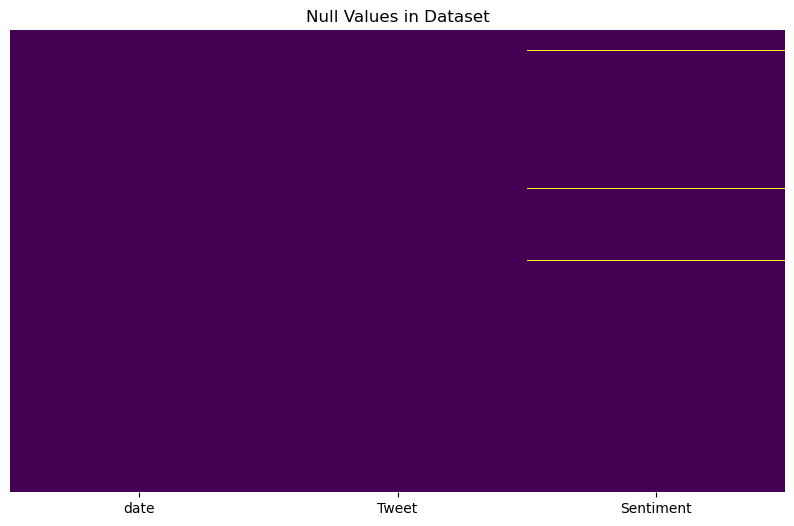

In [11]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Null Values in Dataset')
plt.show()

In [12]:
df = df.dropna(subset=['Sentiment', 'Tweet', 'date'])

In [13]:
df.count()

date         1822
Tweet        1822
Sentiment    1822
dtype: int64

### Drop duplicates and Non-arabic tweet

In [14]:
df = df.drop_duplicates(subset='Tweet', keep='first')

In [15]:
df.count()

date         1719
Tweet        1719
Sentiment    1719
dtype: int64

In [16]:
def filter_farsi_tweets(df):
    # Create a new column to store language detection results
    df['language'] = df['Tweet'].apply(detect)

    # Filter the DataFrame to keep only rows with Arabic language
    filtered_df = df[df['language'] == 'ar']

    # Drop the 'language' column since it's no longer needed
    filtered_df.drop('language', axis=1, inplace=True)

    return filtered_df

In [17]:
filtered_df = filter_farsi_tweets(df)

In [18]:
df = filtered_df


In [19]:
df.count()

date         1555
Tweet        1555
Sentiment    1555
dtype: int64

In [20]:
# def removeEnglishWords(df):
#     x= re.sub('[a-zA-Z0-9]',' ',str(df))
#     return str(x)

# df["Tweet"]= df["Tweet"].apply(removeEnglishWords)
    

In [79]:
# df

## PreProccessing

In [22]:
punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation

In [23]:
# Arabic stop words with nltk
nltk.download('stopwords')
stop_words = stopwords.words()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\iraha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
arabic_diacritics = re.compile("""
                             ّ    | # Shadda
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

In [25]:
def preprocess(text):
    
    #remove punctuations
    translator = str.maketrans('', '', punctuations)
    text = text.translate(translator)
    
    # remove Tashkeel
    text = re.sub(arabic_diacritics, '', text)
    
    #remove longation
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)

    #remove opreating char
    text =re.sub(r'(.)\1+', r'\1',text)

    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)

    #text = ' '.join(word for word in text.split() if word not in stop_words)

    return text

In [26]:
df['Tweet'] = df['Tweet'].apply(preprocess)
print(df.head(5))

                  date  \
0  2020-05-27 04:41:01   
1  2020-05-27 03:47:08   
3  2020-05-27 03:07:36   
4  2020-05-27 01:45:20   
6  2020-05-26 22:49:22   

                                                                                                                                                                                                                    Tweet  \
0  ياخي ارسلت اكثر مره احد خدمني عندي شريحه مسبقه الدفع ابي افعل الجيل الخامس محدود يقبل معي ماي اس سي ليه                                                                                                                  
1  ابي افعل انترنت الجيل الخامس لمده شهر محدود لشريحه كويك نت و رصيد يغطي جربت عشرين مره ماي اس سي و لاضبط امل حل مشكلتي و شكرا والا فعلوها عندكم و خلصنا تو ارسلت بالخاص قالي الموظف حاول مره اخري سلامات حل اسبوع احاول   
3  سلام علكيم عام وانتو بخير انا جيت تطبيق ماي اس سي مالقيت ايفون اكس اس ماكس متوفره                                                                                                

In [27]:
tokenizer = RegexpTokenizer(r'\w+')
df["Tweet"] = df["Tweet"].apply(tokenizer.tokenize)

In [28]:
df["Tweet"].head(10)

0     [ياخي, ارسلت, اكثر, مره, احد, خدمني, عندي, شريحه, مسبقه, الدفع, ابي, افعل, الجيل, الخامس, محدود, يقبل, معي, ماي, اس, سي, ليه]                                                                                                                                      
1     [ابي, افعل, انترنت, الجيل, الخامس, لمده, شهر, محدود, لشريحه, كويك, نت, و, رصيد, يغطي, جربت, عشرين, مره, ماي, اس, سي, و, لاضبط, امل, حل, مشكلتي, و, شكرا, والا, فعلوها, عندكم, و, خلصنا, تو, ارسلت, بالخاص, قالي, الموظف, حاول, مره, اخري, سلامات, حل, اسبوع, احاول]
3     [سلام, علكيم, عام, وانتو, بخير, انا, جيت, تطبيق, ماي, اس, سي, مالقيت, ايفون, اكس, اس, ماكس, متوفره]                                                                                                                                                                
4     [اله, يحيك, تم, طلبها, طريق, ماي, اس, سي, يوم, ويجيني, النت, وتفعل, الخدمه]                                                                                                                         

In [29]:
stopwords_list = stopwords.words('arabic')

In [30]:
stopwords_list

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [31]:
list_To_Str = ' '.join([str(elem) for elem in stopwords_list]) 

In [32]:
list_To_Str

'إذ إذا إذما إذن أف أقل أكثر ألا إلا التي الذي الذين اللاتي اللائي اللتان اللتيا اللتين اللذان اللذين اللواتي إلى إليك إليكم إليكما إليكن أم أما أما إما أن إن إنا أنا أنت أنتم أنتما أنتن إنما إنه أنى أنى آه آها أو أولاء أولئك أوه آي أي أيها إي أين أين أينما إيه بخ بس بعد بعض بك بكم بكم بكما بكن بل بلى بما بماذا بمن بنا به بها بهم بهما بهن بي بين بيد تلك تلكم تلكما ته تي تين تينك ثم ثمة حاشا حبذا حتى حيث حيثما حين خلا دون ذا ذات ذاك ذان ذانك ذلك ذلكم ذلكما ذلكن ذه ذو ذوا ذواتا ذواتي ذي ذين ذينك ريث سوف سوى شتان عدا عسى عل على عليك عليه عما عن عند غير فإذا فإن فلا فمن في فيم فيما فيه فيها قد كأن كأنما كأي كأين كذا كذلك كل كلا كلاهما كلتا كلما كليكما كليهما كم كم كما كي كيت كيف كيفما لا لاسيما لدى لست لستم لستما لستن لسن لسنا لعل لك لكم لكما لكن لكنما لكي لكيلا لم لما لن لنا له لها لهم لهما لهن لو لولا لوما لي لئن ليت ليس ليسا ليست ليستا ليسوا ما ماذا متى مذ مع مما ممن من منه منها منذ مه مهما نحن نحو نعم ها هاتان هاته هاتي هاتين هاك هاهنا هذا هذان هذه هذي هذين هكذا هل هلا هم هما هن هنا هن

In [34]:
y=df['Sentiment']
counter=y.value_counts()

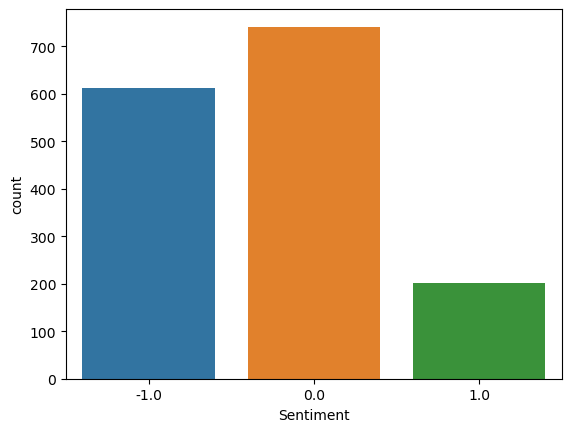

In [35]:
sns.countplot(data= df, x = "Sentiment")
plt.show()

## Feature Extraction

In [36]:
# Initialize the TfidfVectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    ngram_range=(1, 1),
    max_features=10000
)


In [37]:
unigramdataGet = word_vectorizer.fit_transform(df['Tweet'].astype('str'))
unigramdataGet =unigramdataGet.toarray()

In [38]:
vocab = word_vectorizer.get_feature_names_out()

In [39]:
unigramdata_features = pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)

In [40]:
unigramdata_features[unigramdata_features > 0] = 1

In [42]:
y=df['Sentiment']
X=unigramdata_features

# Balancing The data

## using SMOTE:

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=333)

In [154]:
smt = SMOTE(sampling_strategy='all')
print("Before Sampling:", counter)
X_train_sm,y_train_sm= smt.fit_resample(X_train,y_train)

c=y_train_sm.value_counts()
print("After Sampling:", c)

Before Sampling: Sentiment
 0.0    741
-1.0    613
 1.0    201
Name: count, dtype: int64
After Sampling: Sentiment
 0.0    523
-1.0    523
 1.0    523
Name: count, dtype: int64


# Decision Tree (DT)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_train_sm, y_train_sm, test_size=0.30, random_state=333)

In [156]:
print("x_train shape: ", X_train.shape)
print("x_test shape: ", X_test.shape)

print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (1098, 5933)
x_test shape:  (471, 5933)
y_train shape:  (1098,)
y_test shape:  (471,)


In [157]:
Ds=DecisionTreeClassifier(random_state=42)

In [158]:
# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'] }

In [159]:
# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(Ds, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [160]:
# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5}


In [161]:
# Use the best model for predictions
best_ds_classifier = grid_search.best_estimator_
ds_y_pred = best_ds_classifier.predict(X_test)

In [219]:
# Evaluate the model
ds_accuracy = accuracy_score(y_test, ds_y_pred)
print(f'Accuracy: {ds_accuracy}')


ds_precision = precision_score(y_test, ds_y_pred, average="macro")  # 'weighted' considers class imbalance
ds_recall = recall_score(y_test, ds_y_pred, average="macro")
ds_f1 = f1_score(y_test, ds_y_pred, average="macro")

print("Precision:", ds_precision)
print("Recall:", ds_recall)
print("F1-Score:", ds_f1)


Accuracy: 0.6751592356687898
Precision: 0.6818291909127364
Recall: 0.6743670375745848
F1-Score: 0.6770456743436933


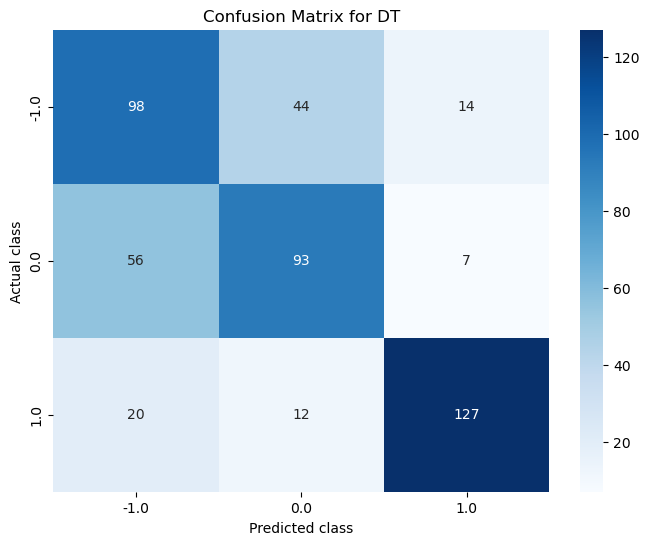

In [163]:
ds_cm = confusion_matrix(y_test, ds_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(ds_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for DT')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()

In [165]:
# Display classification report
print('\nClassification Report:')
print(classification_report(y_test, ds_y_pred))


Classification Report:
              precision    recall  f1-score   support

        -1.0       0.56      0.63      0.59       156
         0.0       0.62      0.60      0.61       156
         1.0       0.86      0.80      0.83       159

    accuracy                           0.68       471
   macro avg       0.68      0.67      0.68       471
weighted avg       0.68      0.68      0.68       471



# Naive Bayes (NB)

In [174]:
y_train.value_counts()

Sentiment
-1.0    367
 0.0    367
 1.0    364
Name: count, dtype: int64

In [175]:
# Ensure 'Tweet' column contains strings
df['Tweet'] = df['Tweet'].astype(str)

In [176]:
# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

In [177]:
# Define the hyperparameter grid
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],  
}

In [178]:
# Use GridSearchCV for hyperparameter tuning
nb_grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
nb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0]}, scoring='accuracy')

In [179]:
# Get the best hyperparameters
best_alpha = nb_grid_search.best_params_['alpha']
print(f'Best alpha: {best_alpha}')

Best alpha: 0.01


In [180]:
# Train the model with the best hyperparameters
nb_classifier = MultinomialNB(alpha=best_alpha)
nb_classifier.fit(X_train, y_train)

# Make predictions
nb_y_pred = nb_classifier.predict(X_test)

# Evaluate the model
nb_accuracy = accuracy_score(y_test, nb_y_pred)
classification_report_str = classification_report(y_test, nb_y_pred)

print(f'Accuracy: {nb_accuracy:.4f}')
print('Classification Report:\n', classification_report_str)

Accuracy: 0.7813
Classification Report:
               precision    recall  f1-score   support

        -1.0       0.78      0.71      0.74       156
         0.0       0.71      0.68      0.69       156
         1.0       0.84      0.95      0.89       159

    accuracy                           0.78       471
   macro avg       0.78      0.78      0.78       471
weighted avg       0.78      0.78      0.78       471



In [218]:
nb_precision = precision_score(y_test, nb_y_pred, average="macro")  # 'weighted' considers class imbalance
nb_recall = recall_score(y_test, nb_y_pred, average="macro")
nb_f1 = f1_score(y_test, nb_y_pred, average="macro")

print("Precision:", nb_precision)
print("Recall:", nb_recall)
print("F1-Score:", nb_f1)

Precision: 0.7773107421687168
Recall: 0.7802370585389453
F1-Score: 0.7770893415765716


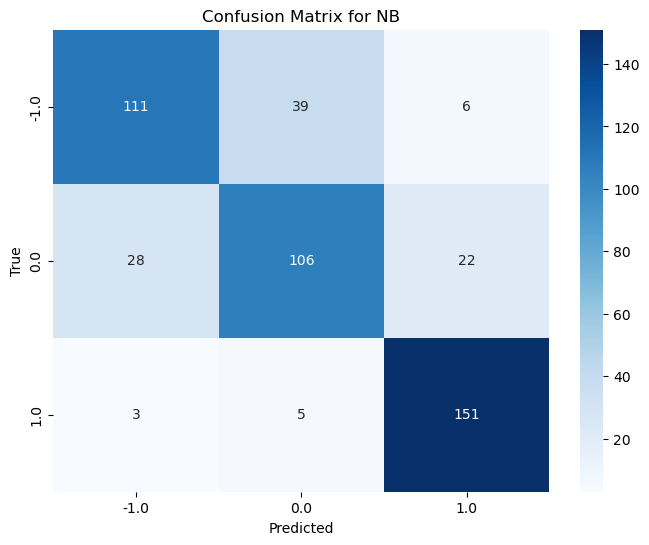

In [183]:
cm = confusion_matrix(y_test, nb_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for NB')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Support Vector Machine (SVM)

In [184]:
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [185]:
rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

In [186]:
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

In [187]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  58.17
F1 (Polynomial Kernel):  55.48


In [188]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  50.96
F1 (RBF Kernel):  47.18


In [189]:
# training a linear SVM classifier 
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test, y_test) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 

In [190]:
svm_model_linear

SVC(C=1, kernel='linear')

In [96]:
cm

array([[ 63,  50,   9],
       [ 31, 116,  20],
       [  1,   7, 144]], dtype=int64)

In [97]:
accuracy

0.7324263038548753

In [98]:
print(classification_report(y_test,svm_predictions))

              precision    recall  f1-score   support

        -1.0       0.66      0.52      0.58       122
         0.0       0.67      0.69      0.68       167
         1.0       0.83      0.95      0.89       152

    accuracy                           0.73       441
   macro avg       0.72      0.72      0.72       441
weighted avg       0.72      0.73      0.72       441



# One-VS-One (OVO):

In [191]:
# Create an SVM classifier using One-vs-One strategy
svm_model_ovo = OneVsOneClassifier(SVC(kernel='linear'))
svm_model_ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=SVC(kernel='linear'))

In [192]:
# Predictions
y_pred_ovo = svm_model_ovo.predict(X_test)

In [193]:
# Evaluate accuracy
accuracy_ovo = accuracy_score(y_test, y_pred_ovo)
print("Accuracy (One-vs-One):", accuracy_ovo)

Accuracy (One-vs-One): 0.7961783439490446


In [220]:
ovo_precision = precision_score(y_test, y_pred_ovo, average="macro")  # 'weighted' considers class imbalance
ovo_recall = recall_score(y_test, y_pred_ovo, average="macro")
ovo_f1 = f1_score(y_test, y_pred_ovo, average='macro')

print("Precision:", ovo_precision)
print("Recall:", ovo_recall)
print("F1-Score:", ovo_f1)

Precision: 0.7922098100001982
Recall: 0.7952346395742622
F1-Score: 0.7927825575645753


# One-Vs-All (OVA):

In [199]:
# Create an SVM classifier using One-vs-All strategy
svm_model_ova = OneVsRestClassifier(SVC(kernel='linear'))
svm_model_ova.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [200]:
# Predictions
y_pred_ova = svm_model_ova.predict(X_test)

In [201]:
# Evaluate accuracy
accuracy_ova = accuracy_score(y_test, y_pred_ova)
print("Accuracy (One-vs-All):", accuracy_ova)

precision_ova = precision_score(y_test, y_pred_ova, average='macro')  # 'weighted' considers class imbalance
recall_ova = recall_score(y_test, y_pred_ova, average='macro')
f1_ova = f1_score(y_test, y_pred_ova, average='macro')

print("Precision:", precision_ova)
print("Recall:", recall_ova)
print("F1-Score:", f1_ova)


Accuracy (One-vs-All): 0.7707006369426752
Precision: 0.7653076997053706
Recall: 0.7695936139332366
F1-Score: 0.7658174857603933


## SVM Optimization:
* (One-vs-All):

In [203]:
tuned_parameters = [{'estimator__kernel': ["linear"], 'estimator__gamma': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
                     'estimator__C': [1, 10, 100, 1000]}]


print("# Tuning hyper-parameters for SVM: " )

ova_clf = GridSearchCV(svm_model_ova, tuned_parameters, cv=5,
                    scoring="accuracy")
ova_clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(ova_clf.best_params_)

# Tuning hyper-parameters for SVM: 
Best parameters set found on development set:
{'estimator__C': 1, 'estimator__gamma': 0.001, 'estimator__kernel': 'linear'}


In [204]:
ova_clf.best_score_

0.7650311332503115

In [205]:
# Use the best model for predictions
ova_best_classifier = ova_clf.best_estimator_
ova_svm_pred = best_classifier.predict(X_test)

In [221]:
# Evaluate the model
ova_accuracy = accuracy_score(y_test, ova_svm_pred)
print(f'Accuracy: {ova_accuracy}')

ova_precision = precision_score(y_test, ova_svm_pred, average="macro")  # 'weighted' considers class imbalance
ova_recall = recall_score(y_test, ova_svm_pred, average="macro")
ova_f1 = f1_score(y_test, ova_svm_pred, average="macro")

print("Precision:", ova_precision)
print("Recall:", ova_recall)
print("F1-Score:", ova_f1)

Accuracy: 0.8492569002123143
Precision: 0.8502886092641085
Recall: 0.8493388163199483
F1-Score: 0.8492340992340992


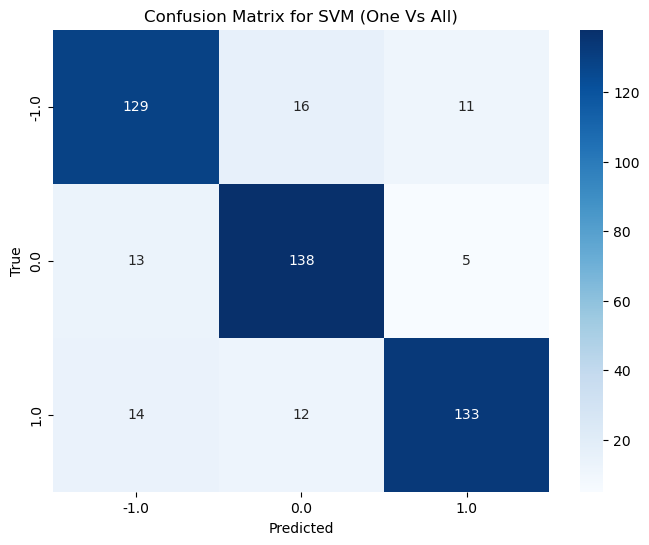

In [207]:
cm = confusion_matrix(y_test, ova_svm_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for SVM (One Vs All)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

* (One-vs-One):

In [209]:
tuned_parameters = [{'estimator__kernel': ["linear"], 'estimator__gamma': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
                     'estimator__C': [1, 10, 100, 1000]}]


print("# Tuning hyper-parameters for SVM: " )

ovo_clf = GridSearchCV(svm_model_ovo, tuned_parameters, cv=5,
                    scoring="accuracy")
ovo_clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(ovo_clf.best_params_)

# Tuning hyper-parameters for SVM: 
Best parameters set found on development set:
{'estimator__C': 1, 'estimator__gamma': 0.001, 'estimator__kernel': 'linear'}


In [210]:
# Use the best model for predictions
ovo_best_classifier = ovo_clf.best_estimator_
ovo_svm_pred = ovo_best_classifier.predict(X_test)

In [211]:
# Evaluate the model
ovo_accuracy = accuracy_score(y_test, ovo_svm_pred)
print(f'Accuracy: {ovo_accuracy}')

ovo_precision = precision_score(y_test, ovo_svm_pred, average='macro')  # 'weighted' considers class imbalance
ovo_recall = recall_score(y_test, ovo_svm_pred, average='macro')
ovo_f1 = f1_score(y_test, ovo_svm_pred, average='macro')

print("Precision:", ovo_precision)
print("Recall:", ovo_recall)
print("F1-Score:", ovo_f1)

Accuracy: 0.7961783439490446
Precision: 0.7922098100001982
Recall: 0.7952346395742622
F1-Score: 0.7927825575645753


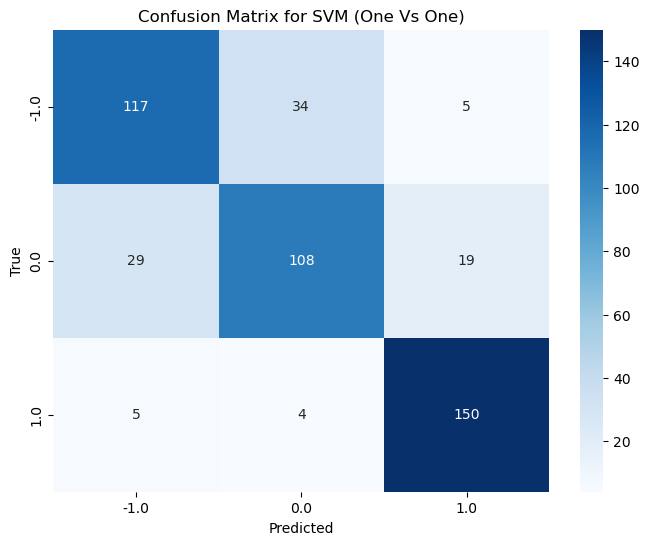

In [216]:
ovo_cm = confusion_matrix(y_test, ovo_svm_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(ovo_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for SVM (One Vs One)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Ensemble Techniques:

In [217]:
# Create a voting classifier
voting_classifier = VotingClassifier(
    estimators=[('ds_classifier', best_ds_classifier), ('nb_classifier', nb_classifier), ('ovo_classifier', ovo_best_classifier), ("ova_classifier",ova_best_classifier)],
    voting='hard'  
)

# Fit the ensemble model on the training data
voting_classifier.fit(X_train, y_train)

# Make predictions using the ensemble model
y_pred = voting_classifier.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Model Accuracy:", accuracy)

Ensemble Model Accuracy: 0.8110403397027601


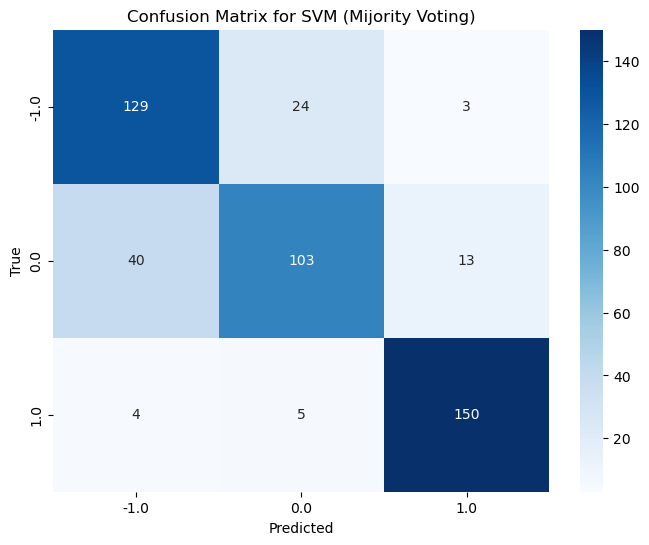

In [225]:
en_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(en_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for SVM (Mijority Voting)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()